# **Text classification with BERT**

### Sentiment analysis of movie reviews

### Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

### Data collection

In [ ]:
# Read the csv file with movie reviwes
df = pd.read_csv('movie_reviews.csv')

Exploratory Data Analysis

In [ ]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B2509840,A566643,User_7918,1,7,5,973217506,Best movie ever,The acting was subpar and the plot was predict...
1,2,B5639642,A118824,User_2720,1,1,5,1043381406,Not worth it,Terrible movie. Waste of time and money. The p...
2,3,B8876173,A239423,User_6502,5,2,5,1253894914,Best movie ever,A thrilling experience from start to finish! T...
3,4,B5413641,A915120,User_8290,5,1,5,1064586735,Absolutely loved it,I really liked the cinematography and the stor...
4,5,B2297772,A270630,User_779,2,1,5,1179119438,Fantastic movie!,Terrible movie. Waste of time and money. The p...


In [ ]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
9995,9996,B1275864,A401789,User_9081,4,8,1,1496946280,Would not recommend,Terrible movie. Waste of time and money. The p...
9996,9997,B8683704,A935980,User_1440,0,9,1,1504120882,Terrible film,I did not enjoy this movie at all. It was very...
9997,9998,B9066523,A265413,User_4276,0,6,1,1299824998,Quite enjoyable,Terrible movie. Waste of time and money. The p...
9998,9999,B5811626,A230318,User_1498,3,1,1,1256394384,Not worth it,This movie was fantastic! The plot was grippin...
9999,10000,B3327920,A359324,User_1056,9,7,1,1008676567,A must-watch,One of the best movies I have seen in a long t...


In [ ]:
df['Text'].value_counts()

,count
Text,
The acting was subpar and the plot was predictable. I was really looking forward to this movie but it did not live up to the hype. The script was poorly written and the pacing was slow. Not recommended.,1044
"An average movie. Nothing special, nothing terrible. The story was okay, but it felt like it dragged on in some parts. The acting was decent but not memorable. Good for a one-time watch.",1020
One of the best movies I have seen in a long time! The storyline was original and the characters were well-developed. The cinematography was stunning and the special effects were seamless. A must-watch!,1020
Terrible movie. Waste of time and money. The plot made no sense and the characters were unlikeable. The dialogue was cringe-worthy and the pacing was all over the place. Do yourself a favor and skip this one.,1019
I did not enjoy this movie at all. It was very boring and the plot was too predictable. The acting was mediocre and I found myself checking my phone multiple times. Would not recommend.,1007
A thrilling experience from start to finish! The plot twists were unexpected and kept me on the edge of my seat. The performances were outstanding and the direction was impeccable. Highly recommend!,1005
I really liked the cinematography and the story. The visuals were stunning and the storyline kept me engaged throughout. The actors did a great job and the direction was superb. Definitely worth a watch.,975
"Not what I expected, but still good. The story had some interesting elements and the actors did a decent job. However, there were some plot holes and the ending felt rushed. Overall, an okay movie.",975
Could have been better with a stronger storyline. The movie had potential but it fell flat in some areas. The acting was good but the plot was weak. It’s worth a watch if you have nothing else to do.,972


In [ ]:
len(df)

10000

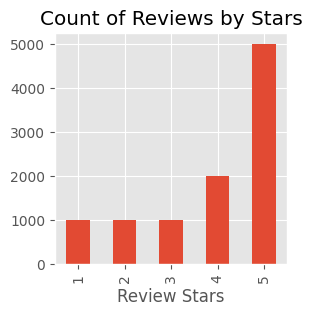

In [ ]:
# Plotting a bar chart of the count of reviews by star rating
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(13, 5))
ax.set_xlabel('Review Stars')
plt.show()

### NLTK

In [ ]:
# Extract a single example sentence from the 'Text' column of the DataFrame
example = df['Text'][50]
print(example)

I did not enjoy this movie at all. It was very boring and the plot was too predictable. The acting was mediocre and I found myself checking my phone multiple times. Would not recommend.


In [ ]:
# Tokenize the example sentence into individual words or tokens
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'did', 'not', 'enjoy', 'this', 'movie', 'at', 'all', '.', 'It']

In [ ]:
# Perform Part-of-Speech (POS) tagging on the tokens (noun, verb or adjective)
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('did', 'VBD'),
 ('not', 'RB'),
 ('enjoy', 'VB'),
 ('this', 'DT'),
 ('movie', 'NN'),
 ('at', 'IN'),
 ('all', 'DT'),
 ('.', '.'),
 ('It', 'PRP')]

In [ ]:
# Perform NER on the POS-tagged tokens
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  did/VBD
  not/RB
  enjoy/VB
  this/DT
  movie/NN
  at/IN
  all/DT
  ./.
  It/PRP
  was/VBD
  very/RB
  boring/JJ
  and/CC
  the/DT
  plot/NN
  was/VBD
  too/RB
  predictable/JJ
  ./.
  The/DT
  acting/NN
  was/VBD
  mediocre/JJ
  and/CC
  I/PRP
  found/VBD
  myself/PRP
  checking/VBG
  my/PRP$
  phone/NN
  multiple/JJ
  times/NNS
  ./.
  Would/MD
  not/RB
  recommend/VB
  ./.)


### Vader sentiment scoring: bag of words approach

In [ ]:
# Initialize the Sentiment Intensity Analyzer from VADER
sia = SentimentIntensityAnalyzer()

In [ ]:
# Compute the sentiment scores for the given text (positive, negative, neutral and compound sentiment)
sia.polarity_scores('I am very entusiatic')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
# Compute the sentiment scores for the given text (positive, negative, neutral and compound sentiment)
sia.polarity_scores('Bad movie, im never gonna watch again')

{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'compound': -0.5423}

In [ ]:
# Compute the sentiment scores for the example sentence extracted earlier (positive, negative, neutral and compound sentiment)
sia.polarity_scores(example)

{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'compound': -0.7454}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Convert the dictionary of results to a DataFrame and transpose it so that IDs are rows
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

# Merge the sentiment scores DataFrame with the original DataFrame
vaders = vaders.merge(df, how='left')
vaders.head(2)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.050,0.950,0.000,-0.2235,B2509840,A566643,User_7918,1,7,5,973217506,Best movie ever,The acting was subpar and the plot was predict...
1,2,0.189,0.748,0.063,-0.6597,B5639642,A118824,User_2720,1,1,5,1043381406,Not worth it,Terrible movie. Waste of time and money. The p...
2,3,0.000,0.728,0.272,0.8879,B8876173,A239423,User_6502,5,2,5,1253894914,Best movie ever,A thrilling experience from start to finish! T...
3,4,0.000,0.531,0.469,0.9647,B5413641,A915120,User_8290,5,1,5,1064586735,Absolutely loved it,I really liked the cinematography and the stor...
4,5,0.189,0.748,0.063,-0.6597,B2297772,A270630,User_779,2,1,5,1179119438,Fantastic movie!,Terrible movie. Waste of time and money. The p...


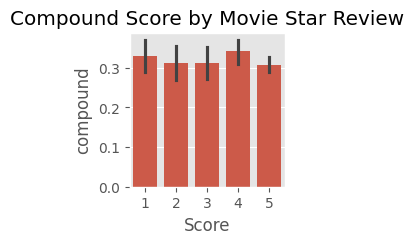

In [ ]:
# Create a bar plot to visualize the compound sentiment score
plt.figure(figsize=(2, 2))
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Movie Star Review')
plt.show()

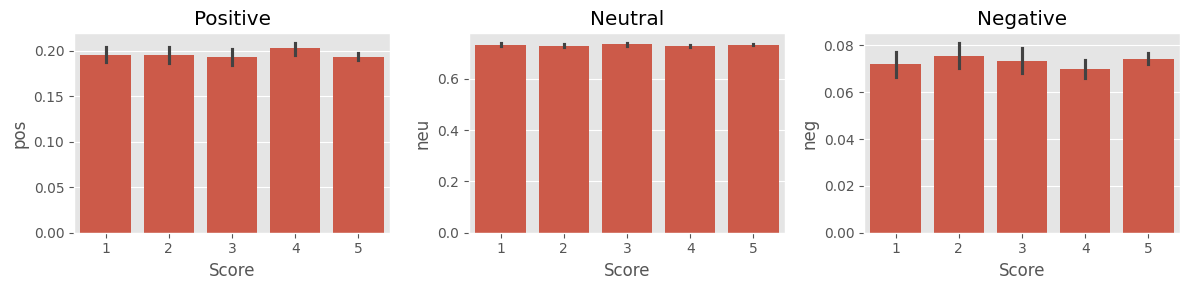

In [ ]:
# Create subplots to visualize positive, neutral, and negative sentiment scores
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### RoBERTa Pretrained Model

In [ ]:
# Load the pre-trained RoBERTa model for sequence classification
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Compute the sentiment scores for the example sentence using the VADER sentiment analyzer
print(example)
sia.polarity_scores(example)

I did not enjoy this movie at all. It was very boring and the plot was too predictable. The acting was mediocre and I found myself checking my phone multiple times. Would not recommend.


{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'compound': -0.7454}

In [ ]:
# Run sentiment analysis using the RoBERTa model on the example sentence
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.98306364, 'roberta_neu': 0.014435837, 'roberta_pos': 0.0025004477}


In [ ]:
def polarity_scores_roberta(example):
    """
    Computes the polarity scores for a given text using a RoBERTa model.

    Parameters:
    example (str): The input text for analysis.

    Returns:
    dict: A dictionary with keys 'roberta_neg', 'roberta_neu', and 'roberta_pos'
          representing the negative, neutral, and positive sentiment scores.
    """
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [ ]:
# Iterate through each row in the DataFrame using tqdm to display a progress bar
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Combines the sentiment analysis results with the original data
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

### Combine and compare

In [ ]:
# Create a pair plot to visualize the relationship between different sentiment scores
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

### Review example

Positive score

In [ ]:
# Query the DataFrame for reviews with a Score of 1 and sort the results by' score in descending order: RoBERTa
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
# Query the DataFrame for reviews with a Score of 1 and sort the results by' score in descending order: VADER
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

Negative score

In [ ]:
# Query the DataFrame for reviews with a Score of 5 and sort the results by score in descending order: RoBERTa
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
# Query the DataFrame for reviews with a Score of 5 and sort the results by score in descending order: VADER
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

### Pipeline

In [ ]:
# The pipeline function automatically loads a pre-trained model and tokenizer for sentiment analysis
sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
# Use the sentiment analysis pipeline to analyze the sentiment of the text
sent_pipeline('I love this movie!')

In [ ]:
# Use the sentiment analysis pipeline to analyze the sentiment of the text
sent_pipeline('I will never gonna watch this again!')

In [ ]:
# Use the sentiment analysis pipeline to analyze the sentiment of the text
sent_pipeline('Noo!!')